In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [59]:
def get_comment(file):
    mydir = 'C:\\Users\\Sandesh\\Desktop\\hate-speech-dataset\\all_files'
    with open(os.path.join(mydir,file+".txt"), 'r', encoding='utf8') as f:
        return f.read().lower()
    return

def load_data(file):
    return pd.read_csv(file)

def append_comment(df,column_name):
    df[column_name] = df['file_id'].apply(lambda x:get_comment(x))
    return df

def create_mapping(df):
    labels = df.label.unique()
    mapping = {}
    for idx,val in enumerate(labels):
        mapping[val] = idx
    return mapping

def set_numeric_label(df):
    mapping = create_mapping(df)
    df['new_label'] = df['label'].apply(lambda s: mapping.get(s))
    return df  

def prepare_dataset():
    file = "C:/Users/Sandesh/Desktop/hate-speech-dataset/annotations_metadata.csv"
    df = load_data(file)
    df = append_comment(df,'text')
    df = set_numeric_label(df)
    return df

# mydir = 'C:\\Users\\Sandesh\\Desktop\\hate-speech-dataset\\all_files'
# df =pd.read_csv("C:/Users/Sandesh/Desktop/hate-speech-dataset/annotations_metadata.csv")
# df['text'] = df['file_id'].apply(lambda x:get_comment(x))

# mapping = {'noHate': 0, 'hate':1, 'relation':2,'idk/skip':3 }
# df['new_label'] = df['label'].apply(lambda s: mapping.get(s))

In [60]:
df = prepare_dataset()

## Without using Relation

All the sentences labelled as `HATE` have been collected, and an equivalent number of `NOHATE` sentences have been randomly
sampled, summing up 2k labelled sentences. 

Training: Test split = 80%:20%

In [3]:
df1 = df.loc[(df["label"]=='hate') | (df["label"]=='noHate')]

In [5]:
df2 = df1[(df1['text'].apply(lambda x: len(x.split()))>=3) & (df1['text'].apply(lambda x: len(x.split()))<=50)]

In [6]:
df2_hate = df2[df2['label']=='hate']
df2_noHate = df2[df2['label']=='noHate']

In [7]:
len(df2_hate), len(df2_noHate)

(1154, 8869)

In [25]:
## Balance the hate and noHate count 
sample_hate = df2_hate.sample(1000)
sample_nohate = df2_noHate.sample(1000)
new_df = pd.concat([sample_hate, sample_nohate], axis=0, join='outer')

In [26]:
# shuffle data
from sklearn.utils import shuffle

df_new = shuffle(new_df)

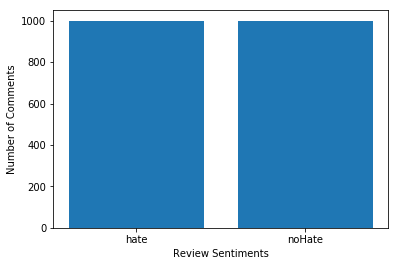

In [27]:
label_count=new_df.groupby('label').count()
plt.bar(label_count.index.values, label_count['text'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Comments')
plt.show()

In [28]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

In [14]:
def create_vocab(X_train,X_test):
    vocab = Counter()
    for text in X_train:
        for word in text.strip().split(' '):
            vocab[word.lower()]+=1
    for text in X_test:
        for word in text.strip().split(' '):
            vocab[word.lower()]+=1
    return vocab

def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i
    return word2index

def get_batch(X_data,y,i,batch_size):
    batches = []
    results = []
    texts = X_data[i*batch_size:i*batch_size+batch_size]
    categories = y[i*batch_size:i*batch_size+batch_size]
    for text in texts:
        layer = np.zeros(total_words,dtype=float)
        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1

        batches.append(layer)

    for category in categories:
        index_y = -1
        if category == 0:
            index_y = 0
        else:
            index_y = 1
        results.append(index_y)
        
    return np.array(batches),np.array(results)

In [16]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class OurNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(OurNet, self).__init__()
        self.layer_1 = nn.Linear(input_size,hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [105]:
## Train Test split
X = df_new.text
y = df_new.new_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [106]:
vocab = create_vocab(X_train,X_test)
total_words = len(vocab)
word2index = get_word_2_index(vocab)

learning_rate = 0.01
num_epochs = 10
batch_size = 150
display_step = 1

# Network Parameters
hidden_size = 100      # 1st layer and 2nd layer number of features
input_size = total_words # Words in vocab
num_classes = 2  

In [107]:
net = OurNet(input_size, hidden_size, num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  
print("Total batches : ",int(X_train.shape[0]/batch_size))
# Train the Model
for epoch in range(num_epochs):
    total_batch = int(X_train.shape[0]/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(X_train,y_train,i,batch_size)
        articles = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        #print("articles",articles)
        #print(batch_x, labels)
        #print("size labels",labels.size())

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, X_train.shape[0]//batch_size, loss.data[0]))

Total batches :  10


c:\python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/10], Step [4/10], Loss: 0.6445
Epoch [1/10], Step [8/10], Loss: 0.6336
Epoch [2/10], Step [4/10], Loss: 0.2442
Epoch [2/10], Step [8/10], Loss: 0.1374
Epoch [3/10], Step [4/10], Loss: 0.0738
Epoch [3/10], Step [8/10], Loss: 0.0285
Epoch [4/10], Step [4/10], Loss: 0.0092
Epoch [4/10], Step [8/10], Loss: 0.0006
Epoch [5/10], Step [4/10], Loss: 0.0088
Epoch [5/10], Step [8/10], Loss: 0.0002
Epoch [6/10], Step [4/10], Loss: 0.0001
Epoch [6/10], Step [8/10], Loss: 0.0001
Epoch [7/10], Step [4/10], Loss: 0.0002
Epoch [7/10], Step [8/10], Loss: 0.0001
Epoch [8/10], Step [4/10], Loss: 0.0000
Epoch [8/10], Step [8/10], Loss: 0.0001
Epoch [9/10], Step [4/10], Loss: 0.0000
Epoch [9/10], Step [8/10], Loss: 0.0001
Epoch [10/10], Step [4/10], Loss: 0.0000
Epoch [10/10], Step [8/10], Loss: 0.0001


In [108]:
correct = 0
total = 0
total_test_data = len(y_test)
batch_x_test,batch_y_test = get_batch(X_test,y_test,0,total_test_data)
articles = Variable(torch.FloatTensor(batch_x_test))
labels = torch.LongTensor(batch_y_test)
outputs = net(articles)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()

print('Accuracy of the network over test articles: %d %%' % (100 * correct / total))

Accuracy of the network over test articles: 72 %


In [109]:
from sklearn.metrics import f1_score

f1_score(y_test, predicted)  

0.7146529562982006

# Experiement 2

## Including relation as hatespeech

In [80]:
df.label.value_counts()

noHate      9507
hate        1196
relation     168
idk/skip      73
Name: label, dtype: int64

In [88]:
df3 = df
df3['label'][df3.label=='relation']= 'hate'
df3 = set_numeric_label(df3)

c:\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [89]:
df3['new_label'].value_counts()

0    9507
1    1364
2      73
Name: new_label, dtype: int64

In [90]:
df3['label'].value_counts()

noHate      9507
hate        1364
idk/skip      73
Name: label, dtype: int64

In [93]:
df3_hate = df3[df3['label']=='hate']
df3_noHate = df3[df3['label']=='noHate']
len(df3_hate), len(df3_noHate)

(1364, 9507)

In [97]:
sample_hate1 = df3_hate.sample(1000)
sample_nohate1 = df3_noHate.sample(1000)

new_df1 = pd.concat([sample_hate1, sample_nohate1], axis=0, join='outer')

In [98]:
df_new1 = shuffle(new_df1)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df_new1.text, df_new1.new_label, test_size = 0.20)

In [102]:
vocab = create_vocab(X_train,X_test)
total_words = len(vocab)
word2index = get_word_2_index(vocab)

learning_rate = 0.01
num_epochs = 10
batch_size = 150
display_step = 1

# Network Parameters
hidden_size = 100      # 1st layer and 2nd layer number of features
input_size = total_words # Words in vocab
num_classes = 2  

In [103]:
net = OurNet(input_size, hidden_size, num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  
print("Total batches : ",int(X_train.shape[0]/batch_size))
# Train the Model
for epoch in range(num_epochs):
    total_batch = int(X_train.shape[0]/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(X_train,y_train,i,batch_size)
        articles = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        #print("articles",articles)
        #print(batch_x, labels)
        #print("size labels",labels.size())

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, X_train.shape[0]//batch_size, loss.data[0]))

Total batches :  10


c:\python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/10], Step [4/10], Loss: 0.6425
Epoch [1/10], Step [8/10], Loss: 0.6391
Epoch [2/10], Step [4/10], Loss: 0.2235
Epoch [2/10], Step [8/10], Loss: 0.2149
Epoch [3/10], Step [4/10], Loss: 0.0066
Epoch [3/10], Step [8/10], Loss: 0.0567
Epoch [4/10], Step [4/10], Loss: 0.0021
Epoch [4/10], Step [8/10], Loss: 0.0125
Epoch [5/10], Step [4/10], Loss: 0.0322
Epoch [5/10], Step [8/10], Loss: 0.0202
Epoch [6/10], Step [4/10], Loss: 0.0009
Epoch [6/10], Step [8/10], Loss: 0.0015
Epoch [7/10], Step [4/10], Loss: 0.0005
Epoch [7/10], Step [8/10], Loss: 0.0020
Epoch [8/10], Step [4/10], Loss: 0.0002
Epoch [8/10], Step [8/10], Loss: 0.0011
Epoch [9/10], Step [4/10], Loss: 0.0001
Epoch [9/10], Step [8/10], Loss: 0.0009
Epoch [10/10], Step [4/10], Loss: 0.0001
Epoch [10/10], Step [8/10], Loss: 0.0007


In [104]:
correct = 0
total = 0
total_test_data = len(y_test)
batch_x_test,batch_y_test = get_batch(X_test,y_test,0,total_test_data)
articles = Variable(torch.FloatTensor(batch_x_test))
labels = torch.LongTensor(batch_y_test)
outputs = net(articles)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()

print('Accuracy of the network over test articles: %d %%' % (100 * correct / total))

Accuracy of the network over test articles: 67 %
